In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv("h1b_cleaned_encoded.csv")

C:\Users\thakk\AppData\Local\Temp\ipykernel_21144\4239751877.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("h1b_cleaned_encoded.csv")


In [4]:
df = df.drop(columns=['COUNTRY_OF_CITIZENSHIP'])

In [5]:
def clean_naics(row):

    naics = str(row['NAICS_CODE'])
    new_naics = []
    for char in naics:
        if char == '-':
            pass
        else:
            new_naics.append(char)
    return ''.join(new_naics)



In [6]:
df['NAICS_CODE'] = df.apply(clean_naics,axis=1)

In [7]:
df['target'].value_counts()

target
1    88232
0     2132
Name: count, dtype: int64

In [14]:
df_train,df_test = train_test_split(df,test_size=0.3)

In [16]:
df_train['target'].value_counts()

target
1    61729
0     1525
Name: count, dtype: int64

1. Resampling df_train to create a balanced training set using sklearn utils resample

In [11]:
from sklearn.utils import resample

In [17]:
df_majority = df_train[(df_train['target']==1)] 
df_minority = df_train[(df_train['target']==0)] 

df_minority_upsampled = resample(df_minority, replace=True,n_samples= 61729,random_state=101)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])

In [19]:
df_upsampled['target'].value_counts()

target
0    61729
1    61729
Name: count, dtype: int64

In [20]:
X_train = df_upsampled.drop('target',axis=1)
y_train = df_upsampled['target']

X_test = df_test.drop('target',axis=1)
y_test = df_test['target']


In [21]:
rf_classifier_resampled = RandomForestClassifier()

rf_classifier_resampled.fit(X_train,y_train)

RandomForestClassifier()

In [22]:
predictions_resampled = rf_classifier_resampled.predict(X_test)

In [23]:
cl_report_resampled = classification_report(y_test,predictions_resampled)

In [24]:
print(cl_report_resampled)

              precision    recall  f1-score   support

           0       0.10      0.17      0.12       607
           1       0.98      0.96      0.97     26503

    accuracy                           0.95     27110
   macro avg       0.54      0.57      0.55     27110
weighted avg       0.96      0.95      0.95     27110



In [26]:
feature_importance = pd.DataFrame({"Feature":X.columns,"Importance":rf_classifier_resampled.feature_importances_}).sort_values("Importance",ascending=False)

<Axes: xlabel='Importance', ylabel='Feature'>

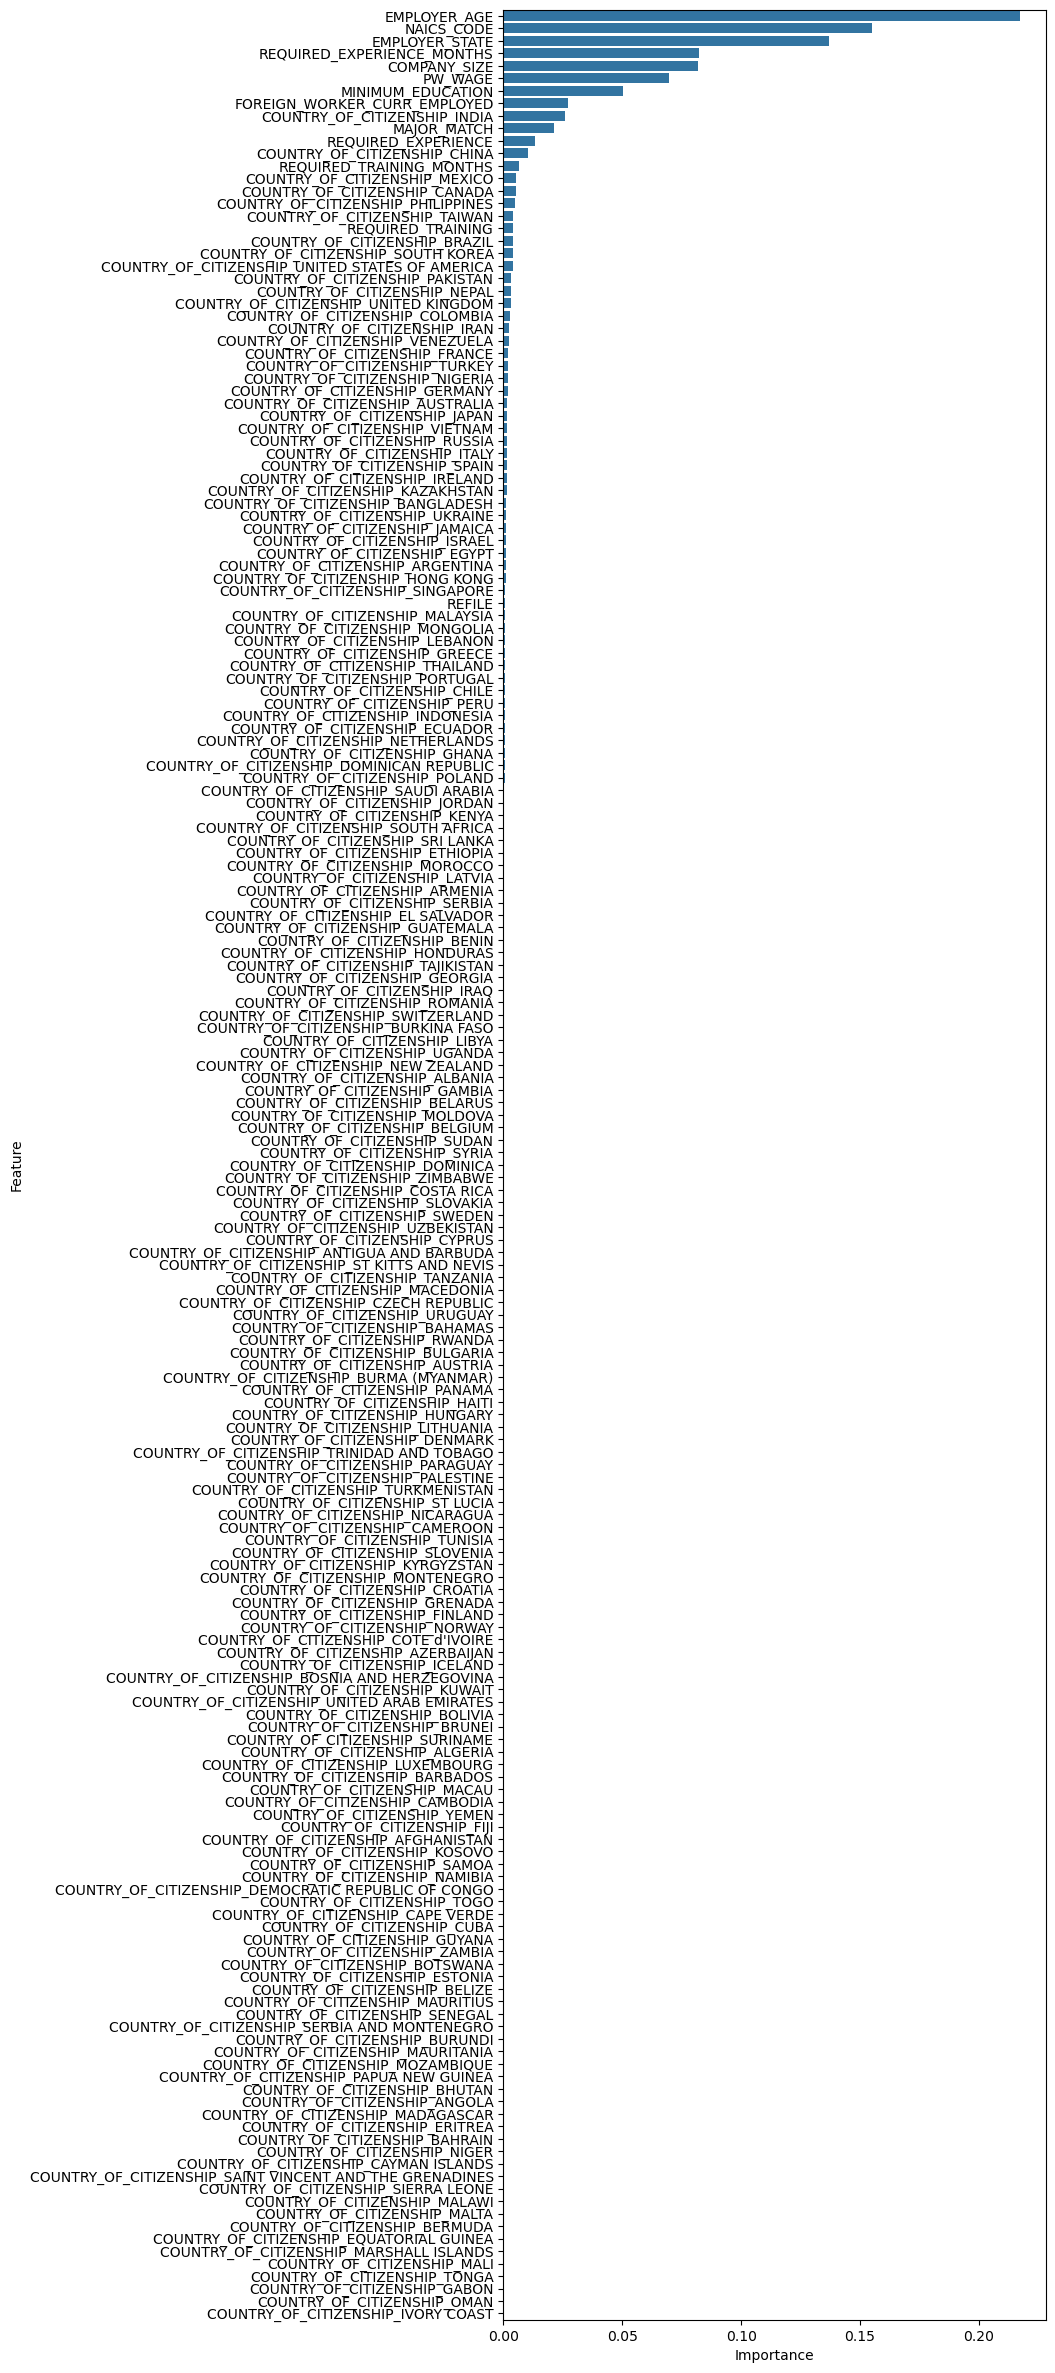

In [27]:
plt.figure(figsize=(7, 30))
sns.barplot(x='Importance',y='Feature',data=feature_importance)

In [30]:
important_features = feature_importance[feature_importance['Importance']>0.025].Feature.values

X_imp = df_upsampled[important_features]
X_test_imp = df_test[important_features]


rf_upsampled_imp = RandomForestClassifier()
rf_upsampled_imp.fit(X_imp,y_train)

RandomForestClassifier()

In [31]:
predictions_resampled_imp = rf_upsampled_imp.predict(X_test_imp)

In [32]:
cl_report_resampled_imp = classification_report(y_test,predictions_resampled_imp)

In [33]:
print(cl_report_resampled_imp)

              precision    recall  f1-score   support

           0       0.07      0.18      0.10       607
           1       0.98      0.95      0.96     26503

    accuracy                           0.93     27110
   macro avg       0.53      0.56      0.53     27110
weighted avg       0.96      0.93      0.94     27110



### The results are still biased towards the majority class even though we used balanced training set.

### Let's try using BalancedRandomForestClassifier by iblearn